Student: Michael Menjares
1. Be sure to perform a train test split on the train.csv so you can evaluate your models.
2. Create and evaluate 3 iterations of a deep learning model to predict housing prices using the techniques you have learned to optimize your model's performance. Be sure to include some form of regularization with at least one model.
3. Select your best model!

# Imports and Read

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

# Keras
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

In [58]:
url = 'train.csv'
df_original = pd.read_csv(url)
df = df_original.copy()
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [60]:
print(f'{df.duplicated().sum()} duplicates')

0 duplicates


In [61]:
# Count null values in each column
null_count = df.isnull().sum().sort_values(ascending = False)

# Filter columns with null values
columns_with_nulls = null_count[null_count > 0].index

for cols in columns_with_nulls:
    print(f'{cols}: {null_count[cols]}')

PoolQC: 1453
MiscFeature: 1406
Alley: 1369
Fence: 1179
FireplaceQu: 690
LotFrontage: 259
GarageYrBlt: 81
GarageCond: 81
GarageType: 81
GarageFinish: 81
GarageQual: 81
BsmtFinType2: 38
BsmtExposure: 38
BsmtQual: 37
BsmtCond: 37
BsmtFinType1: 37
MasVnrArea: 8
MasVnrType: 8
Electrical: 1


In [62]:
for col in null_count.index:
    print(f'{df[col].value_counts()}\n')

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

Grvl    50
Pave    41
Name: Alley, dtype: int64

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
        ... 
137.0      1
141.0      1
38.0       1
140.0      1
46.0       1
Name: LotFrontage, Length: 110, dtype: int64

2005.0    65
2006.0    59
2004.0    53
2003.0    50
2007.0    49
          ..
1927.0     1
1900.0     1
1906.0     1
1908.0     1
1933.0     1
Name: GarageYrBlt, Length: 97, dtype: int64

TA    1326
Fa      35
Gd       9
Po       7
Ex       2
Name: GarageCond, dtype: int64

Attchd     870
Detchd     387
BuiltIn     88
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64

Unf    605
RFn    422
Fin    352
Name: GarageFinish, dtype: int64

TA    1

# Preprocessing

In [67]:
# Split
target = 'SalePrice'
drop_cols = ['Id']
drop_cols = [target] + drop_cols
X = df.drop(drop_cols, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [68]:
# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputers
cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')
num_imputer = SimpleImputer(strategy='constant', fill_value=0)

# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Numeric pipeline
numeric_pipe = make_pipeline(num_imputer, scaler)
numeric_pipe

# Categorical pipeline
categorical_pipe = make_pipeline(cat_imputer, ohe)
categorical_pipe

# Tuples for Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)

# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000270B07461C0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000270B07462B0>)])

In [69]:
# fit on train
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000270B07461C0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000270B07462B0>)])

In [70]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [71]:
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (1095, 300)




# Modeling

In [72]:
# Learning history plotting function
def plot_history(history):
  """Takes a keras model learning history and plots each metric"""
  
  metrics = history.history.keys()
  
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()

## Model 1
One layer with as many nodes as features (300)
Linear Output since regression

In [77]:
# create model architecture
input_dim = X_train_processed.shape[1]

reg_model = Sequential()
 
#start with one layer with as many nodes as features
reg_model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))

reg_model.add(Dense(1, activation='linear'))
 
reg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 1)                 301       
                                                                 
Total params: 90,601
Trainable params: 90,601
Non-trainable params: 0
_________________________________________________________________


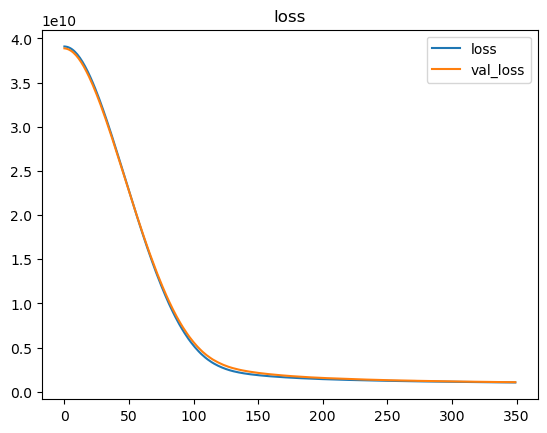

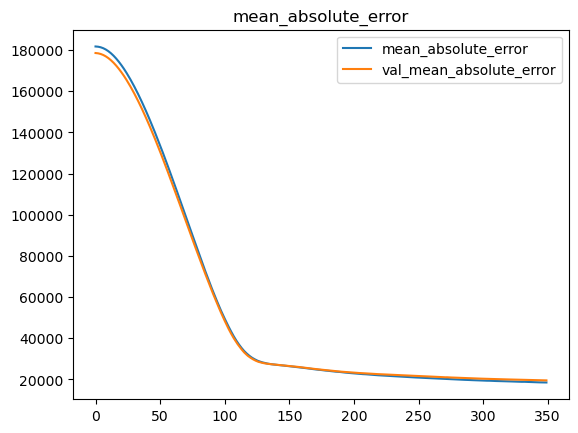

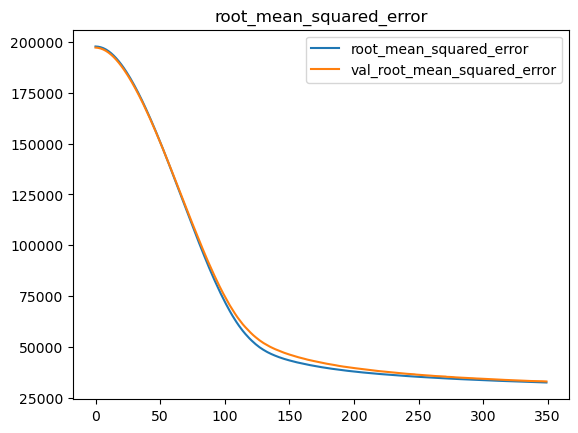

12/12 [==============================] - 0s 3ms/step
final RMSE: 33051.43538231295
final MAE: 19551.924614726027
final R2: 0.8440615006890498
CPU times: total: 4min 14s
Wall time: 58 s


In [74]:
%%time

# compile model with additional metrics
reg_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

history = reg_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=350,
                        verbose=0)

# plot learning
plot_history(history)

# evaluate model
y_pred = reg_model.predict(X_test_processed)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

## Model 2
- Increase Epochs to 550
- Add Early Stopping
- Add One layer with as half many nodes as features (150)


In [87]:
# create model architecture
input_dim = X_train_processed.shape[1]

reg_model = Sequential()
 
#start with one layer with as many nodes as features
reg_model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))

#add layer with half nodes
reg_model.add(Dense(input_dim*.5, activation='relu'))

reg_model.add(Dense(1, activation='linear'))
 
reg_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 300)               90300     
                                                                 
 dense_15 (Dense)            (None, 150)               45150     
                                                                 
 dense_16 (Dense)            (None, 1)                 151       
                                                                 
Total params: 135,601
Trainable params: 135,601
Non-trainable params: 0
_________________________________________________________________


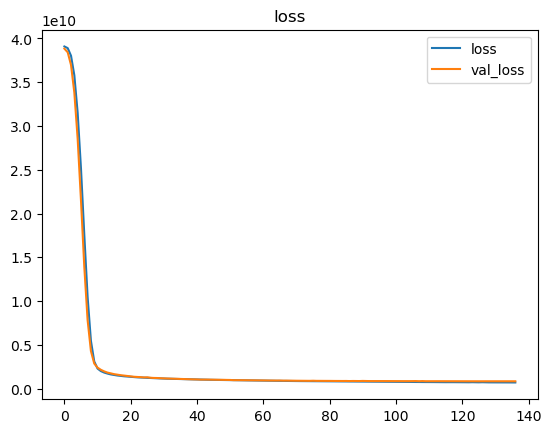

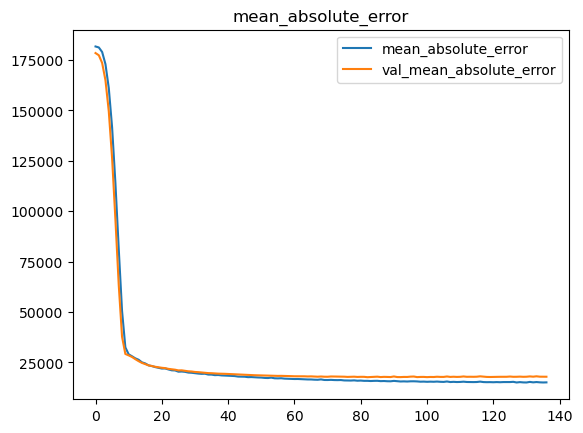

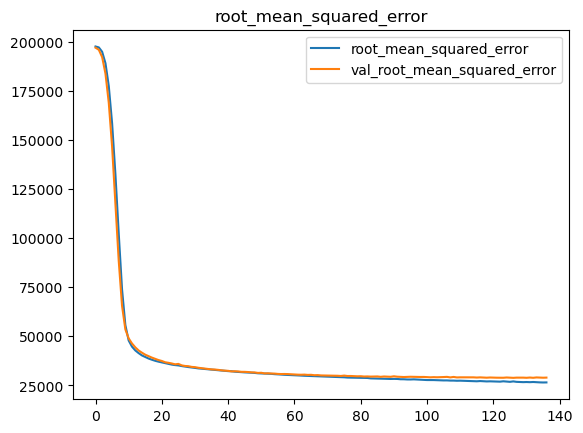

12/12 [==============================] - 0s 3ms/step
final RMSE: 28969.841141009438
final MAE: 17918.62734375
final R2: 0.8801977629445104
CPU times: total: 1min 59s
Wall time: 26.1 s


In [88]:
%%time

# compile model with additional metrics
reg_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

history = reg_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=550,
                        verbose=0
                        #add early stopping
                        ,callbacks=[EarlyStopping(patience=10)]
                       )

# plot learning
plot_history(history)

# evaluate model
y_pred = reg_model.predict(X_test_processed)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

## Model 3
- Add Dropout layers (0.05) for Regularization

In [92]:
# create model architecture
input_dim = X_train_processed.shape[1]

reg_model = Sequential()
 
#start with one layer with as many nodes as features
reg_model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))

#add Dropout
reg_model.add(Dropout(.05))

#add layer with half nodes
reg_model.add(Dense(input_dim*.5, activation='relu'))

#add Dropout
reg_model.add(Dropout(.05))

reg_model.add(Dense(1, activation='linear'))
 
reg_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 300)               90300     
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 dense_24 (Dense)            (None, 150)               45150     
                                                                 
 dropout_5 (Dropout)         (None, 150)               0         
                                                                 
 dense_25 (Dense)            (None, 1)                 151       
                                                                 
Total params: 135,601
Trainable params: 135,601
Non-trainable params: 0
_________________________________________________________________


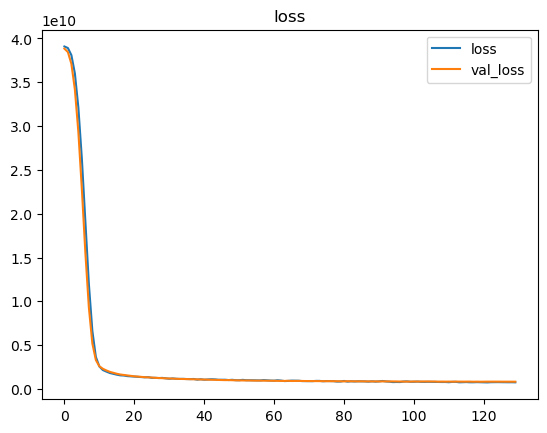

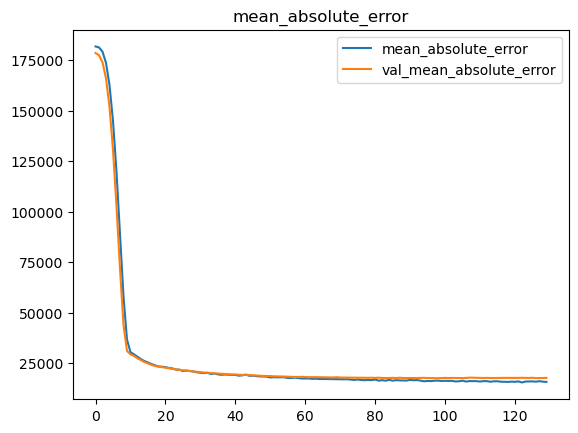

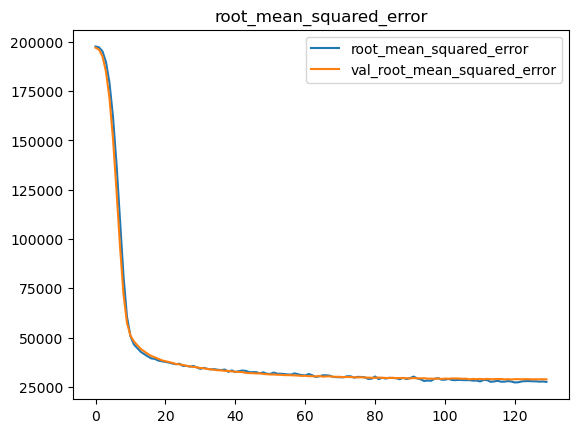

12/12 [==============================] - 0s 3ms/step
final RMSE: 28782.446482049352
final MAE: 17684.67020547945
final R2: 0.8817426584177049
CPU times: total: 1min 52s
Wall time: 25.9 s


In [93]:
%%time

# compile model with additional metrics
reg_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

history = reg_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=550,
                        verbose=0
                        #add early stopping
                        ,callbacks=[EarlyStopping(patience=10)]
                       )

# plot learning
plot_history(history)

# evaluate model
y_pred = reg_model.predict(X_test_processed)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

## Model 4
- Increase complexity by increasing nodes (x0.5 to x1) on second layer

In [94]:
# create model architecture
input_dim = X_train_processed.shape[1]

reg_model = Sequential()
 
#start with one layer with as many nodes as features
reg_model.add(Dense(input_dim, input_dim=input_dim, activation='relu'))

#add Dropout
reg_model.add(Dropout(.05))

#add layer with half nodes
reg_model.add(Dense(input_dim, activation='relu'))

#add Dropout
reg_model.add(Dropout(.05))

reg_model.add(Dense(1, activation='linear'))
 
reg_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 300)               90300     
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_27 (Dense)            (None, 300)               90300     
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_28 (Dense)            (None, 1)                 301       
                                                                 
Total params: 180,901
Trainable params: 180,901
Non-trainable params: 0
_________________________________________________________________


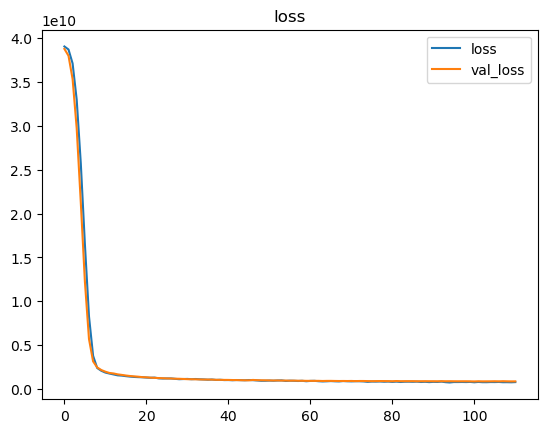

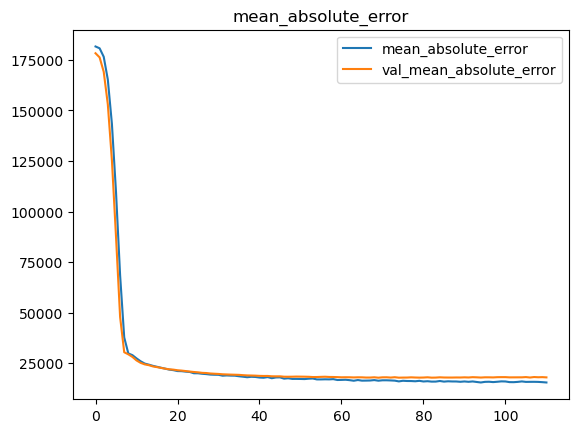

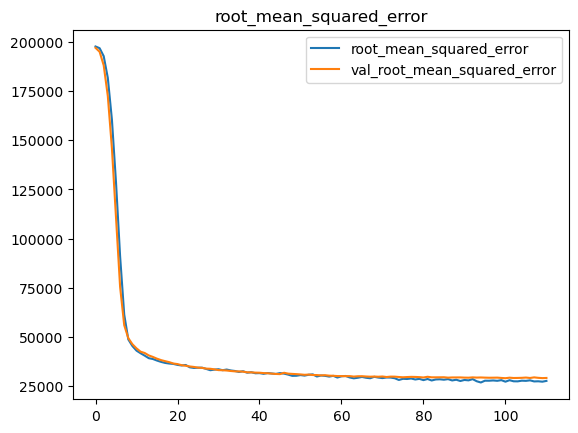

12/12 [==============================] - 0s 3ms/step
final RMSE: 29102.741840466286
final MAE: 17993.536686643834
final R2: 0.8790960432573643
CPU times: total: 1min 46s
Wall time: 25.3 s


In [95]:
%%time

# compile model with additional metrics
reg_model.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

history = reg_model.fit(X_train_processed, y_train,
                        validation_data = (X_test_processed, y_test),
                        epochs=550,
                        verbose=0
                        #add early stopping
                        ,callbacks=[EarlyStopping(patience=10)]
                       )

# plot learning
plot_history(history)

# evaluate model
y_pred = reg_model.predict(X_test_processed)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

# Best Model
The best model was # 3 since it had the highest R2 of 0.881 and the lowest MAE of $17,684 